<h1>Проект: Статистический анализ данных<h1>

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки
абонентская плата отсутствует;
стоимость одной минуты поездки — 
8
8 рублей;
стоимость старта (начала поездки) — 
50
50 рублей;
с подпиской Ultra
абонентская плата — 
199
199 рублей в месяц;
стоимость одной минуты поездки — 
6
6 рублей;
стоимость старта — бесплатно.

Описание данных


В основных данных есть информация о пользователях, их поездках и подписках.


Пользователи — users_go.csv
user_id	уникальный идентификатор пользователя
name	имя пользователя
age	возраст
city	город
subscription_type	тип подписки (free, ultra)


Поездки — rides_go.csv
user_id	уникальный идентификатор пользователя
distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
date	дата совершения поездки


Подписки — subscriptions_go.csv
subscription_type	тип подписки
minute_price	стоимость одной минуты поездки по данной подписке
start_ride_price	стоимость начала поездки
subscription_fee	стоимость ежемесячного платежа

Проанализирую данные и проверю некоторые гипотезы, которые могут помочь бизнесу вырасти.Добавлю библиотеки, которыми буду пользоваться


In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn

### Загрузка данных

#### считаем файлы и сохраним их в датафреймы


In [2]:
user = pd.read_csv('/datasets/users_go.csv')
ride = pd.read_csv('/datasets/rides_go.csv')
subscription = pd.read_csv('/datasets/subscriptions_go.csv')

#### выведем первые строки каждого датафрейма и узнаем информацию о них

In [3]:
user.info()
ride.info()
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

In [4]:
user.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
ride.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
subscription.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Предобработка данных

#### Приведу столбец date к типу даты pandas.

In [7]:
ride['date'] = pd.to_datetime(ride['date'], format = '%Y-%m-%d')
ride.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [8]:
ride.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


#### Создаю новый столбец с номером месяца на основе столбца date.


In [9]:
ride['date_month'] = pd.DatetimeIndex(ride['date']).month
ride.head()

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### Проверю наличие пропущенных значений и дубликатов в датафреймах и обработаю их

##### в user

In [10]:
user.duplicated().sum()

31

In [11]:
user.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

#####  в ride

In [12]:
ride.duplicated().sum()

0

In [13]:
ride.isna().sum()

user_id       0
distance      0
duration      0
date          0
date_month    0
dtype: int64

#####  в subscription

In [14]:
subscription.duplicated().sum()

0

In [15]:
subscription.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенных значений нет, а дубликаты есть только в user. Проверим что за дубликаты.

In [16]:
user = user.drop_duplicates()
user.duplicated().sum()

0

### Исследовательский анализ данных

#### Опишим и визуализируем частоту встречаемости городов:

Text(0, 0.5, 'Частота встречаемости')

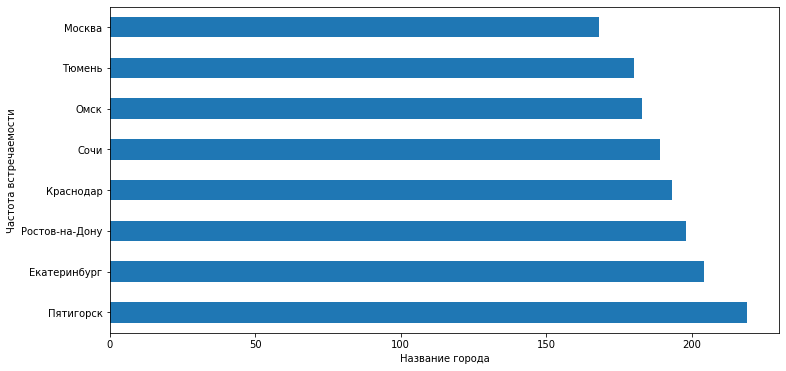

In [17]:
city = user['city'].value_counts()
city.plot(kind='barh', x='city', ylim=(0,300), style = 'o-', figsize=(12, 6))
plt.xlabel("Название города")
plt.ylabel("Частота встречаемости")

#### соотношение пользователей с подпиской и без подписки

<AxesSubplot:>

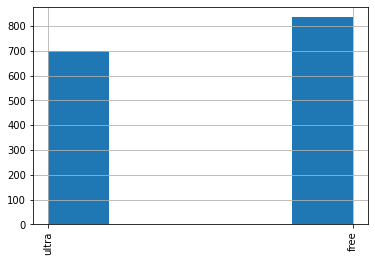

In [18]:
user['subscription_type']. hist(bins=5, xrot=90)

пользователей без подписки осказалось больше

#### возраст пользователей

<AxesSubplot:>

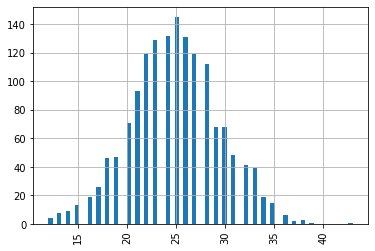

In [19]:
user['age'].hist(bins=70, xrot = 90)

большее количество пользователей в возрасет 25 лет 

####  расстояние, которое пользователь преодолел за одну поездку

<AxesSubplot:>

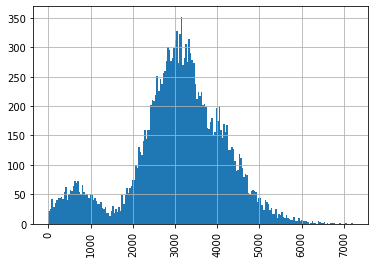

In [20]:
ride['distance'].hist(bins=200, xrot=90)

самокатами чаще всего пользуются для поездок от 2,5 км до 4 км

####  продолжительность поездок

<AxesSubplot:>

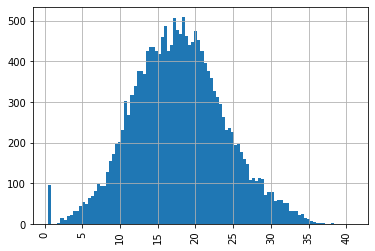

In [21]:
ride['duration'].hist(bins=100, xrot=90)

<AxesSubplot:>

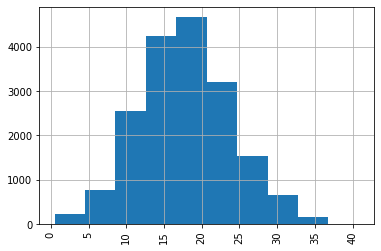

In [22]:
ride['duration'].hist(bins=10, xrot=90)

чаще всего поездка длится от 10 до 20 минут

### Объединение данных

#### Объединим данные о пользователях, поездках и подписках в один датафрейм.


In [23]:
data_1 = user.merge(ride, how='left')
data_1.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [24]:
data = data_1.merge(subscription, how='left')
data['duration'] = np.ceil(data['duration']) 
data['distance'] = np.ceil(data['distance'])

data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,755.0,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,27.0,2021-08-28,8,6,0,199


In [25]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
date_month           0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### Создаю ещё 2 датафрейма из датафрейма, созданного на этапе 4.1. 

пользователи с подпиской:

In [26]:
data_free = data[data['subscription_type'].isin(['free'])]
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2516.0,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,847.0,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4005.0,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1206.0,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3048.0,18.0,2021-02-14,2,8,50,0


In [27]:
data_ultra = data[data['subscription_type'].isin(['ultra'])]
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,755.0,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,27.0,2021-08-28,8,6,0,199


####  Визуализирую информацию о расстоянии и времени поездок для пользователей обеих категорий.

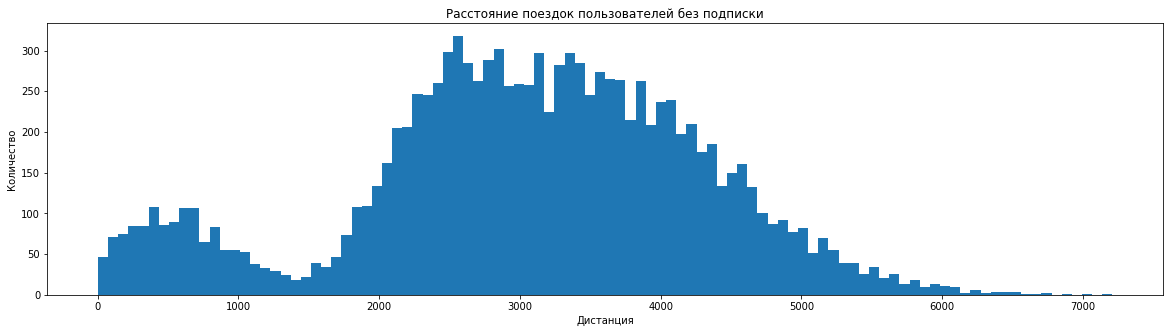

In [28]:
plt.figure(figsize=(20,5))
plt.hist(data_free['distance'], bins = 100)
plt.title('Расстояние поездок пользователей без подписки')
plt.ylabel('Количество')
plt.xlabel('Дистанция')
plt.show()

Пик поездок приходится на дистанцию от 2.5 до 3.5 км

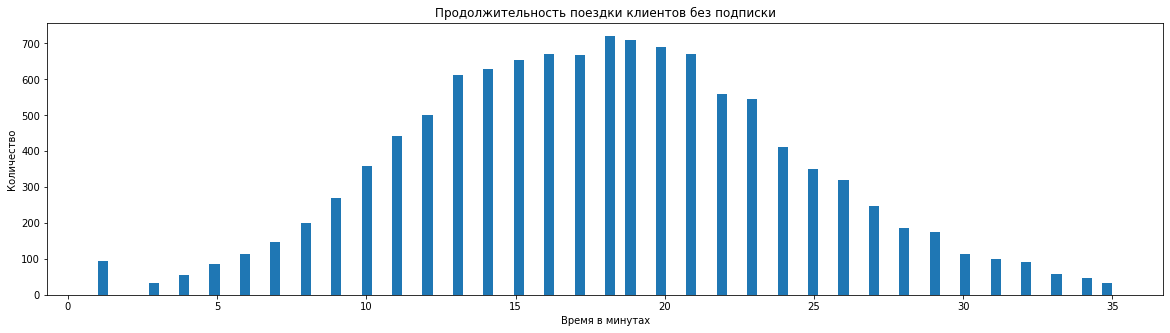

In [29]:
plt.figure(figsize=(20,5))
plt.hist(data_free['duration'], bins = 100)
plt.title('Продолжительность поездки клиентов без подписки')
plt.ylabel('Количество')
plt.xlabel('Время в минутах')
plt.show()

Из графиков можно сказать, что пик продолжительности поездки клиента без подписки приходится на 12-25 минут, с наибольшем количеством поездок на расстояния от 2.5 до 3.5 км

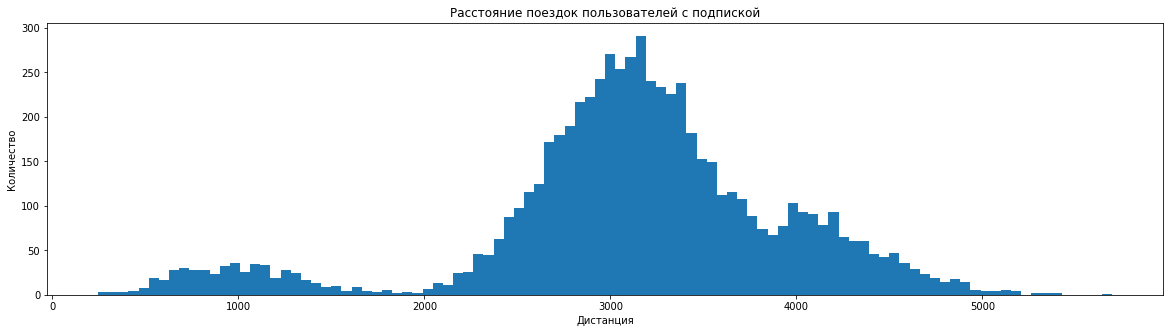

In [30]:
plt.figure(figsize=(20,5))
plt.hist(data_ultra['distance'], bins = 100)
plt.title('Расстояние поездок пользователей c подпиской')
plt.ylabel('Количество')
plt.xlabel('Дистанция')
plt.show()

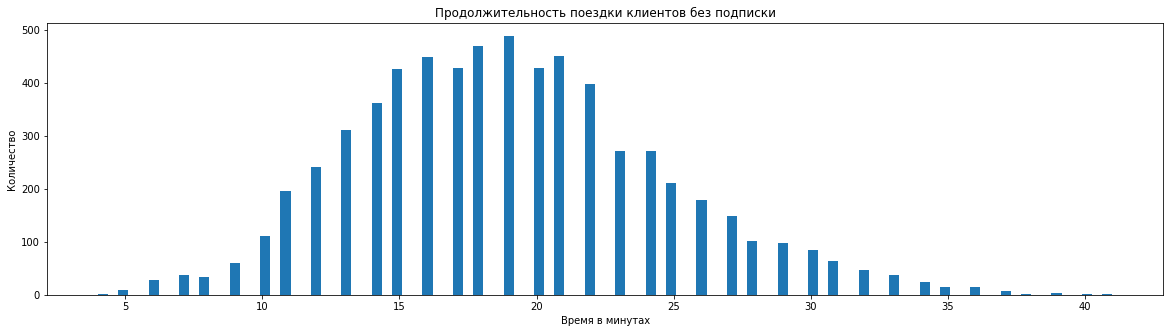

In [31]:
plt.figure(figsize=(20,5))
plt.hist(data_ultra['duration'], bins = 100)
plt.title('Продолжительность поездки клиентов без подписки')
plt.ylabel('Количество')
plt.xlabel('Время в минутах')
plt.show()

из графиков можно сказать, что продолжительность поездки клиента с подпиской занимает 12-23 минут, с наибольшим количеством поездок на дистанции 2.8 - 3.4 км

### Подсчёт выручки

####  Создаю датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [32]:
agg_data = data.pivot_table(
    index = ['user_id', 'date_month'], 
    values = ['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'], 
    aggfunc = {'distance': 'sum', 'duration': 'sum', 'minute_price': 'median', 'start_ride_price': 'median', 'subscription_fee': 'median', 'user_id': 'count'}
)
agg_data.columns = ['distance', 'duration', 'minute_price',  'start_ride_price', 'subscription_fee' ,'user_id']
agg_data.head(20)


distance  duration  minute_price  start_ride_price  \
user_id date_month                                                       
1       1             7028.0      42.0             6                 0   
        4              755.0       7.0             6                 0   
        8             6724.0      46.0             6                 0   
        10            5811.0      32.0             6                 0   
        11            7005.0      56.0             6                 0   
        12            6753.0      28.0             6                 0   
2       3            10190.0      63.0             6                 0   
        4             6165.0      40.0             6                 0   
        6             3256.0      14.0             6                 0   
        7             6781.0      48.0             6                 0   
        8              924.0       7.0             6                 0   
        10            2825.0      19.0             6                 0   
        12            3829.0      12.0             6                 0   
3       1             3062.0      13.0             6                 0   
        2             5422.0      39.0             6                 0   
        4             2957.0      21.0             6                 0   
        5             9065.0      63.0             6                 0   
        7            10921.0      67.0             6                 0   
        9             2892.0      23.0             6                 0   
        12            2594.0      13.0             6                 0   

                    subscription_fee  user_id  
user_id date_month                             
1       1                        199        2  
        4                        199        1  
        8                        199        2  
        10                       199        2  
        11                       199        3  
        12                       199        2  
2       3                        199        3  
        4                        199        2  
        6                        199        1  
        7                        199        2  
        8                        199        1  
        10                       199        1  
        12                       199        1  
3       1                        199        1  
        2                        199        2  
        4                        199        1  
        5                        199        3  
        7                        199        3  
        9                        199        1  
        12                       199        1

полученные данные отображеныв таблице помесячно для каждого пользователя

####  В этот же датафрейм добавлю столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обращаюсь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.

In [33]:
agg_data['monthly_revenue'] = (agg_data['user_id']*agg_data['start_ride_price']) + (
    agg_data['minute_price'] * agg_data['duration']+ agg_data['subscription_fee']
)
agg_data.head(10)     

distance  duration  minute_price  start_ride_price  \
user_id date_month                                                       
1       1             7028.0      42.0             6                 0   
        4              755.0       7.0             6                 0   
        8             6724.0      46.0             6                 0   
        10            5811.0      32.0             6                 0   
        11            7005.0      56.0             6                 0   
        12            6753.0      28.0             6                 0   
2       3            10190.0      63.0             6                 0   
        4             6165.0      40.0             6                 0   
        6             3256.0      14.0             6                 0   
        7             6781.0      48.0             6                 0   

                    subscription_fee  user_id  monthly_revenue  
user_id date_month                                              
1       1                        199        2            451.0  
        4                        199        1            241.0  
        8                        199        2            475.0  
        10                       199        2            391.0  
        11                       199        3            535.0  
        12                       199        2            367.0  
2       3                        199        3            577.0  
        4                        199        2            439.0  
        6                        199        1            283.0  
        7                        199        2            487.0

### Проверка гипотез

#### . Проверю, тратят ли пользователи с подпиской больше времени на поездки?

- Н0: пользователи тратят больше времени времени на поездки.
- Н1: пользователи не тратят больше времени на поездки.

In [59]:
ultra1 = data_ultra['duration']
free1 = data_free['duration']

results = st.ttest_ind(ultra1, free1, alternative='greater')
alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')


1.2804098316645618e-34
Отвергаем нулевую гипотезу


нет, пользователи с подпиской тратят больше времени

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверю, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

- Н0: Среднее расстояние, которое проезжают пользователи с подпиской за 1 поездку равна 3130 метров.
- Н1: Среднее расстояние, которое проезжают пользователи с подпиской за 1 поездку больше 3130 метров.

In [2]:
results = st.ttest_1samp(data_ultra['distance'], 3130,alternative='greater')
alpha = 0.05
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')


NameError: name 'st' is not defined

среднее расстояние, которое проезжают пользователи с подпиской и без за одну поездку не првышает 3130 метров.

#### Проверю гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
- Н0: Выручка от пользователей с подпиской и без неё по месяцам равны:
- Н1: Выручка от пользователей с подпиской по месяцам больше, чем без неё:

In [34]:
with_subscription = agg_data.loc[agg_data['subscription_fee'] == 199]['monthly_revenue']
without_subscription = agg_data.loc[agg_data['subscription_fee'] == 0]['monthly_revenue']

alpha = 0.05
results = st.ttest_ind(with_subscription, without_subscription, alternative='greater')
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

2.8130926188487286e-35
Отвергаем нулевую гипотезу


выручка от пользователей с подпиской по месяцам больше, чем без неё

#### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Для проверки данного теста можно использовать генеральную выборку до и после изменения, тк тут две зависимые парные выборки. Можно проверить гипотезой о равенстве, методом scipy.stats.ttest_rel()

### Вывод

по Иследовательскому анализу:

    - Больше всего пользователей в Пятигорске и меньше всего в Москве;
    - Пользователей с подпиской больше;
    - Больше всего пользователей в возрасте 25 лет;
    - В основном пользователи проезжают 2.5 - 4 км за одну поездку;
    - Чаще всего поездка длятся от 10 до 20 минут;
    - Пик продолжительности поездки клиента без подписки приходится на 12-25 минут, с наибольшим количеством поездок на расстояния от 2.5 до 3.5 км;
    - Пик продолжительности поездки клиента с подпиской занимает 12-23 минут, с наибольшим количеством поездок на дистанции 2.8 - 3.4 км;
    
по Статистичческому анализу данных: 

    - Пользователи с подпиской не тратят больше времени
    - Среднее расстояние, которое проезжают пользователи с подпиской и без за одну поездку не првышает 3130 метров.
    - Выручка от пользователей с подпиской по месяцам больше, чем без неё
    